## Gradient Descent Extensions: Momentum and Adam - Radosław Kawa
### 0. Methods

In [3]:
import numpy as np
from abc import ABC, abstractmethod

class Problem(ABC):
    @abstractmethod
    def __call__(self, x: np.ndarray) -> float:
        """Compute the function value at point x."""
        raise NotImplementedError
    
    @abstractmethod
    def grad(self, x: np.ndarray) -> np.ndarray:
        """Compute the gradient at point x."""
        raise NotImplementedError

class Sphere(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(x**2)
    
    def grad(self, x: np.ndarray) -> np.ndarray:
        return 2 * x

class Rosenbrock(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)
    
    def grad(self, x: np.ndarray) -> np.ndarray:
        grad = np.zeros_like(x)
        n = x.size
        grad[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
        for i in range(1, n - 1):
            grad[i] = 200 * (x[i] - x[i-1]**2) - 400 * x[i] * (x[i+1] - x[i]**2) - 2 * (1 - x[i])
        grad[-1] = 200 * (x[-1] - x[-2]**2)
        return grad

class Rastrigin(Problem):
    def __call__(self, x: np.ndarray) -> float:
        A = 10
        n = x.size
        return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))
    
    def grad(self, x: np.ndarray) -> np.ndarray:
        A = 10
        return 2 * x + 2 * np.pi * A * np.sin(2 * np.pi * x)


In [4]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def prepare_mesh_grid(
    problem: Problem,
    bounds: tuple[float, float] = (-5.0, 5.0),
    grid_size: int = 50,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    x_vals = np.linspace(bounds[0], bounds[1], grid_size)
    y_vals = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)

    Z = np.zeros_like(X)
    for i in range(grid_size):
        for j in range(grid_size):
            xy = np.array([X[i, j], Y[i, j]])
            Z[i, j] = problem(xy)

    return X, Y, Z, x_vals, y_vals


def plot_3d_surface(
    problem: Problem,
    grid_size: int = 50,
):
    X, Y, Z, _, _ = prepare_mesh_grid(problem=problem, grid_size=grid_size)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")

    ax.set_title(problem.__class__.__name__)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")

    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

def plot_contour_and_paths(
    problem: Problem,
    paths: list[np.ndarray],
    grid_size: int = 200,
    title: str = "",
):
    """
    Create an interactive contour plot of a 2D function and overlay multiple optimization paths.

    Args:
        problem: An instance of a Problem class.
        paths: List of numpy arrays; each array is of shape (epochs, 2) containing an optimization trajectory.
        title: Title for the plot.
    """
    _, _, Z, x_vals, y_vals = prepare_mesh_grid(problem, grid_size=grid_size)

    fig = go.Figure(
        data=go.Contour(
            x=x_vals,
            y=y_vals,
            z=Z,
            colorscale="Viridis",
            contours=dict(showlines=False),
            colorbar=dict(title="Function Value"),
        )
    )

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'pink', 'brown']
    
    for idx, path in enumerate(paths):
        color_idx = idx % len(colors)
        fig.add_trace(
            go.Scatter(
                x=path[:, 0],
                y=path[:, 1],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(width=2, color=colors[color_idx]),
                name=f"Run {idx+1}",
                showlegend=True,
            )
        )

    fig.update_layout(
        title=title, xaxis_title="x", yaxis_title="y", width=800, height=700,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.show()

### 1. Getting familiar with optimization test problems

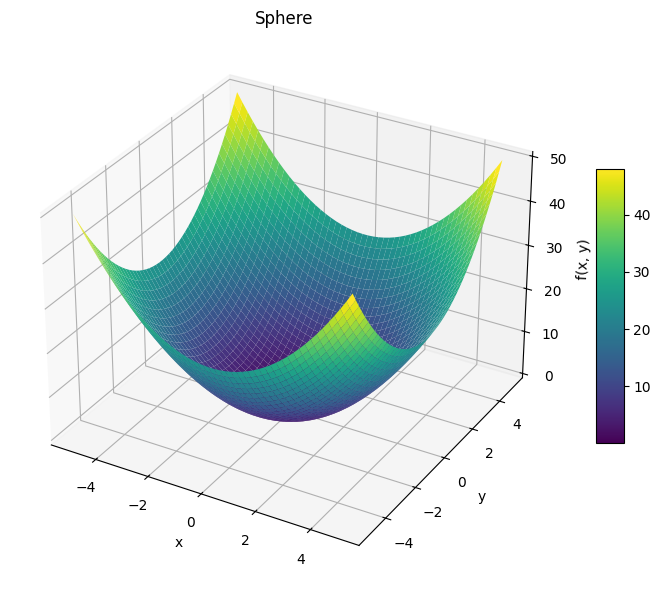

In [84]:
plot_3d_surface(Sphere())
plot_contour_and_paths(Sphere(), [np.array([[0, 0]])], title="Sphere")

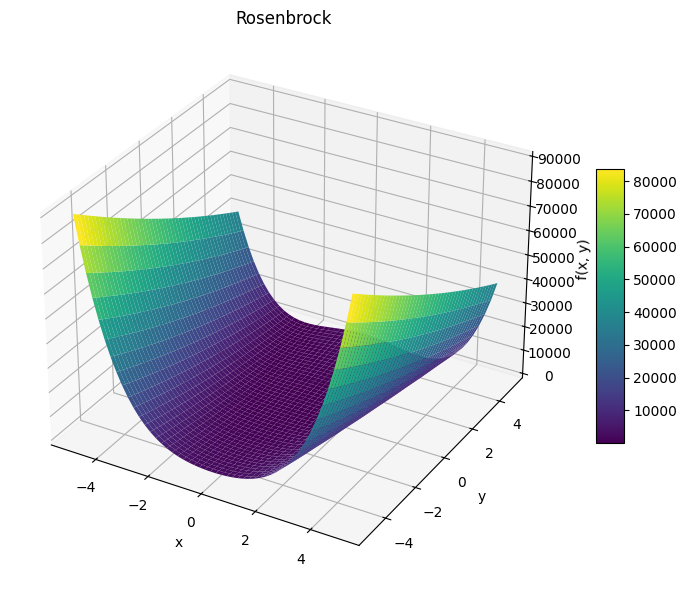

In [85]:
plot_3d_surface(Rosenbrock())
plot_contour_and_paths(Rosenbrock(), [np.array([[0, 0]])], title="Rosenbrock")

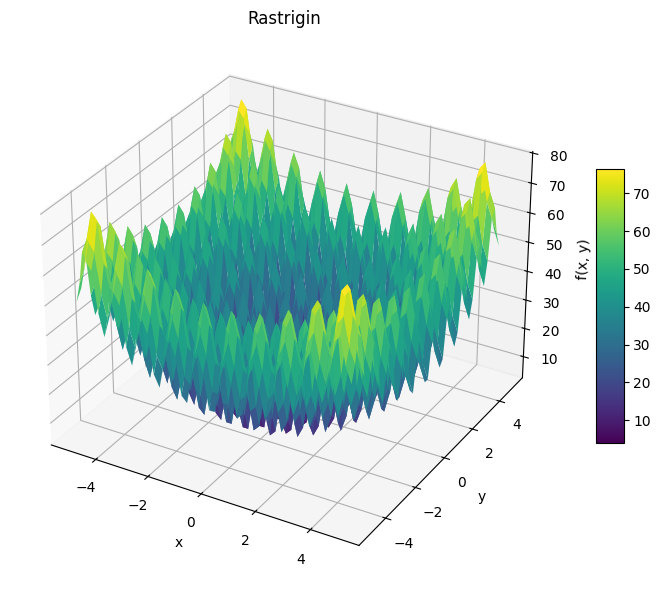

In [86]:
plot_3d_surface(Rastrigin())
plot_contour_and_paths(Rastrigin(), [np.array([[0,0]])], title="Rastrigin")


- Sphere function appears easiest to optimize because it is a convex function with a single global minimum at (0, 0).
- Rastrigin function appears hardestcto optimize because it has many local minima and is highly multimodal.
- Rosenbrock function is also hard to optimize because it is a non-convex function with a narrow, curved valley that leads to the global minimum at (1, 1).

### 2. Momentum method

In [102]:
def momentum(
    problem: Problem,
    initial_solution: np.ndarray,
    alpha: float,
    beta: float,
    number_of_epochs: int,
    clip_value: float = 1.0
):
    x = initial_solution
    v = np.zeros_like(x)
    path = [x.copy()]
    velocities = [v.copy()]

    for _ in range(number_of_epochs):
        grad = problem.grad(x)
        # grad = np.clip(grad, -clip_value, clip_value)  # Clip the gradients
        v = beta * v + alpha * grad
        x = x - v
        path.append(x.copy())
        velocities.append(v.copy())

    return np.array(path), np.array(velocities)

### 3. Experiments with Momentum

In [103]:
def plot_function_values(problem, paths: list, legend_labels: list, title=str):
    for path, label in zip(paths, legend_labels):
        function_values = [problem(x) for x in path]
        plt.plot(function_values, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Function Value")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_function_velocities(paths: list, legend_labels: list, title=str):
    for path, label in zip(paths, legend_labels):
        velocity_norms = [np.linalg.norm(v) for v in path]
        plt.plot(velocity_norms, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Velocity Norm")
    plt.title(title)
    plt.legend()
    plt.show()

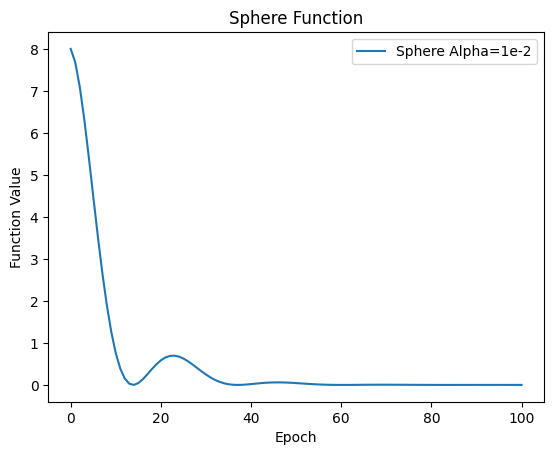

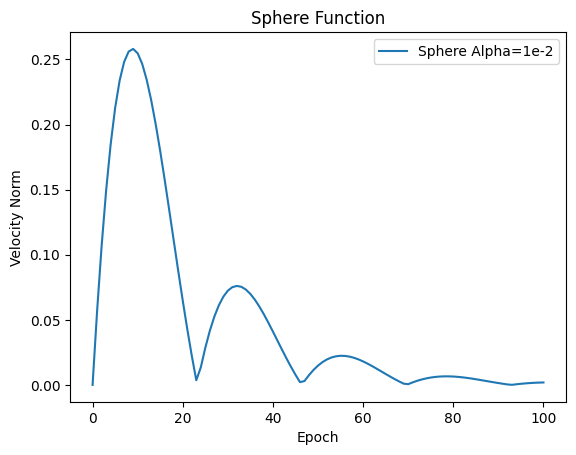

In [104]:
initial_solution = np.array([2.0, 2.0])
beta = 0.9
number_of_epochs = 100

alpha = 1e-2
problem = Sphere()
path, velocities = momentum(problem, initial_solution, alpha, beta, number_of_epochs)
plot_function_values(problem, [path], ["Sphere Alpha=1e-2"], "Sphere Function")
plot_function_velocities([velocities], ["Sphere Alpha=1e-2"], "Sphere Function")

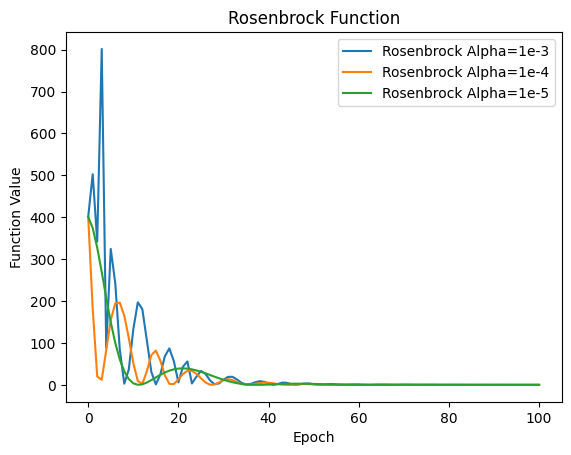

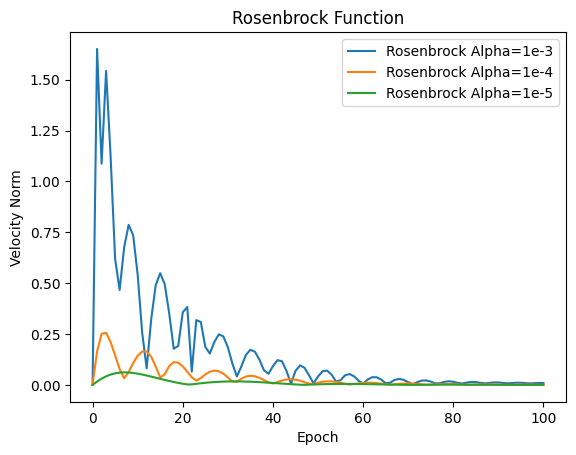

In [107]:
paths, velocities = [], []

problem = Rosenbrock()
for alpha in [1e-3, 1e-4, 1e-5]:
    path, velocity = momentum(problem, initial_solution, alpha, beta, number_of_epochs)
    paths.append(path)
    velocities.append(velocity)    

plot_function_values(problem, paths, ["Rosenbrock Alpha=1e-3", "Rosenbrock Alpha=1e-4", "Rosenbrock Alpha=1e-5"], "Rosenbrock Function")
plot_function_velocities(velocities, ["Rosenbrock Alpha=1e-3", "Rosenbrock Alpha=1e-4", "Rosenbrock Alpha=1e-5"], "Rosenbrock Function")


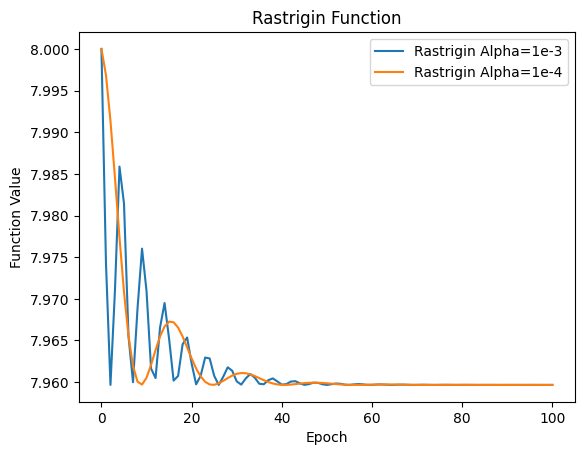

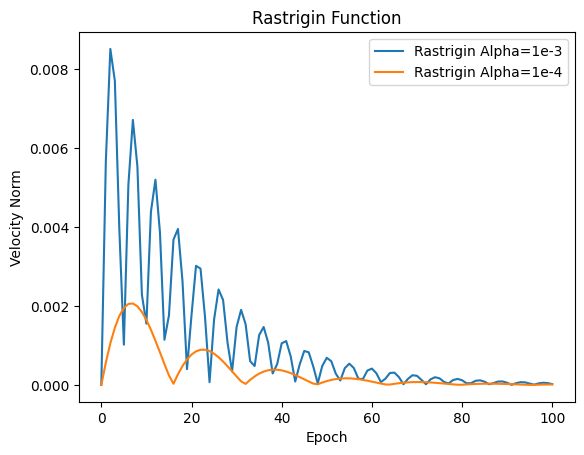

In [108]:
paths, velocities = [], []

problem = Rastrigin()
for alpha in [1e-3, 1e-4]:
    path, velocity = momentum(problem, initial_solution, alpha, beta, number_of_epochs)
    paths.append(path)
    velocities.append(velocity)

plot_function_values(problem, paths, ["Rastrigin Alpha=1e-3", "Rastrigin Alpha=1e-4"], "Rastrigin Function")
plot_function_velocities(velocities, ["Rastrigin Alpha=1e-3", "Rastrigin Alpha=1e-4"], "Rastrigin Function")

It seems that the velocity norm decreases as the optimization progresses. This is expected as the velocity is a moving average of the gradients, which should become smaller as the optimization converges. The velocity norm can be used as a proxy for the convergence speed, as it decreases as the optimization progresses.   

### 4. Momentum Hyperparameters

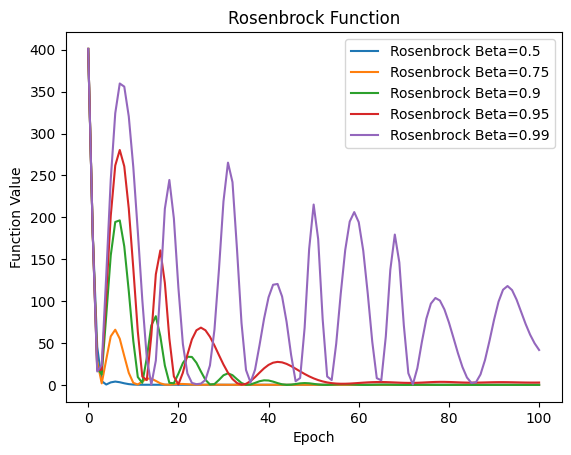

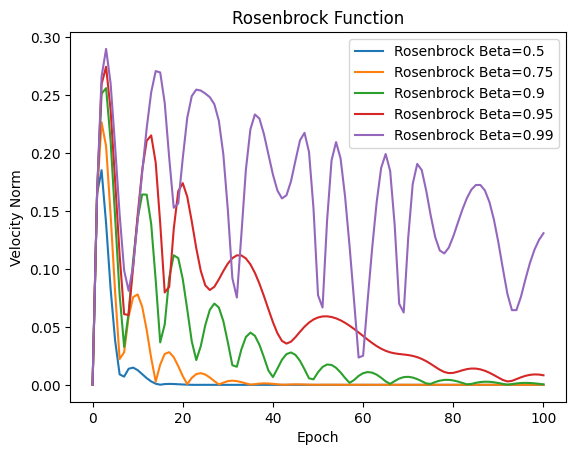

In [109]:
initial_solution = np.array([2.0, 2.0])
alpha = 1e-4
number_of_epochs = 100
betas = [0.5, 0.75, 0.9, 0.95, 0.99]

paths, velocities = [], []

problem = Rosenbrock()
for beta in betas:
    path, velocity = momentum(problem, initial_solution, alpha, beta, number_of_epochs)
    paths.append(path)
    velocities.append(velocity)

plot_function_values(problem, paths, [f"Rosenbrock Beta={beta}" for beta in betas], "Rosenbrock Function")
plot_function_velocities(velocities, [f"Rosenbrock Beta={beta}" for beta in betas], "Rosenbrock Function")



Increasing β makes the optimization faster, but it can also make the optimization unstable.
If β is too large, the optimization may oscillate around the minimum or even diverge.
In practice, we need to find a good balance between the speed of convergence and stability.

### 5. Adam

In [110]:
def adam(
    problem: Problem,
    initial_solution: np.ndarray,
    alpha: float,
    beta1: float,
    beta2: float,
    number_of_epochs: int,
    epsilon: float = 1e-8
):
    x = initial_solution
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    path = [x.copy()]

    for t in range(1, number_of_epochs + 1):
        g = problem.grad(x)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g**2
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        x = x - alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        path.append(x.copy())

    return np.array(path)

### 6. Comparing Adam with Momentum

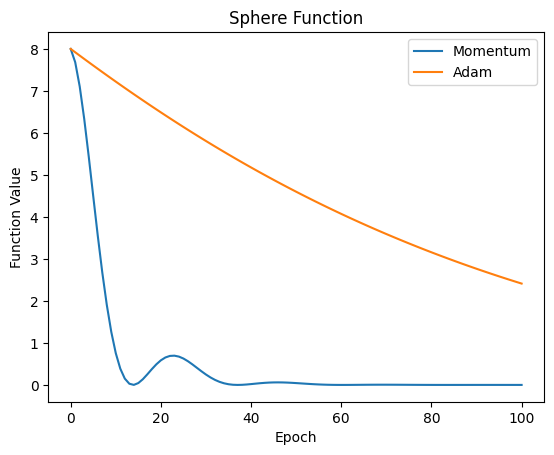

In [128]:
initial_solution = np.array([2.0, 2.0])
number_of_epochs = 100

alpha = 0.01
beta = 0.9

beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

problem = Sphere()
path_momentum, _ = momentum(problem, initial_solution, alpha, beta, number_of_epochs)
path_adam = adam(problem, initial_solution, alpha, beta1, beta2, number_of_epochs, epsilon)

plot_contour_and_paths(problem, [path_momentum, path_adam], title="Sphere - Momentum vs. Adam")
plot_function_values(problem,[path_momentum, path_adam], ["Momentum", "Adam"], "Sphere Function")


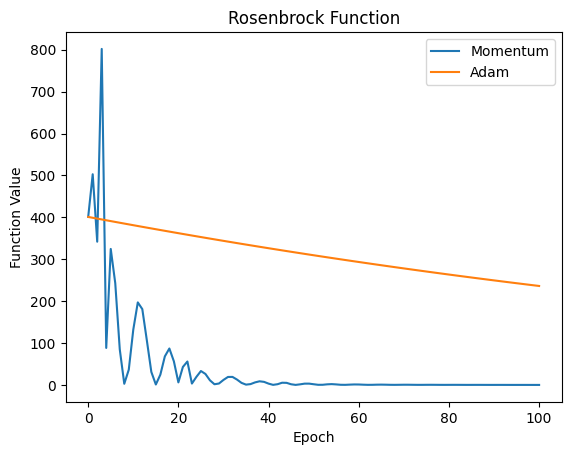

In [133]:
# I had to change alpha for momentum because of numerical instability (too large numbers)
problem = Rosenbrock()
path_momentum, _ = momentum(problem, initial_solution, 0.001, beta, number_of_epochs)
path_adam = adam(problem, initial_solution, 0.001, beta1, beta2, number_of_epochs, epsilon)

plot_contour_and_paths(problem, [path_momentum, path_adam], title="Rosenbrock - Momentum vs. Adam")
plot_function_values(problem,[path_momentum, path_adam], ["Momentum", "Adam"], "Rosenbrock Function")

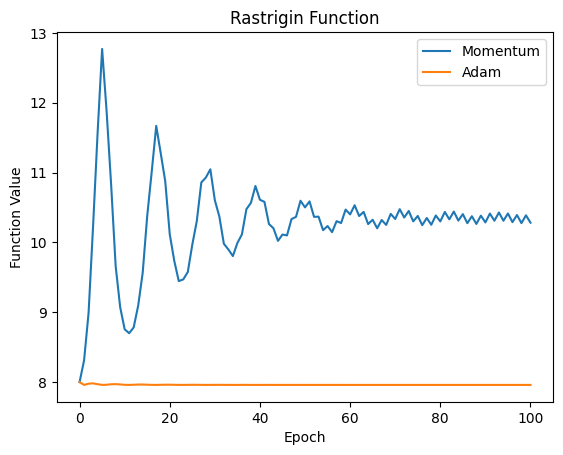

In [130]:
problem = Rastrigin()
path_momentum, _ = momentum(problem, initial_solution, alpha, beta, number_of_epochs)
path_adam = adam(problem, initial_solution, alpha, beta1, beta2, number_of_epochs, epsilon)

plot_contour_and_paths(problem, [path_momentum, path_adam], title="Rastrigin - Momentum vs. Adam")
plot_function_values(problem,[path_momentum, path_adam], ["Momentum", "Adam"], "Rastrigin Function")
